In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.base import TransformerMixin,BaseEstimator
import matplotlib.pyplot as plt



In [2]:
# 加载数据集A
heart_2020_cleaned = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2020/heart_2020_cleaned.csv')
print(heart_2020_cleaned.shape)
X_2020 = heart_2020_cleaned.drop('HeartDisease', axis=1)
y_2020 = heart_2020_cleaned['HeartDisease']
y_2020 = y_2020.map({'Yes':1,'No':0})

# 加载数据集B
heart_2022 = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2022/heart_2022_no_nans.csv')
print(heart_2022.shape)
X_2022 = heart_2022.drop('HadHeartAttack', axis=1)
y_2022 = heart_2022['HadHeartAttack']
y_2022 = y_2022.map({'Yes':1,'No':0})

# 加载数据集C（假设结构类似于数据集B）
heart = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/heart.csv')
print(heart.shape)
X_heart = heart.drop('output', axis=1)
y_heart = heart['output']


(319795, 18)
(246022, 40)
(303, 14)


In [3]:
class CustomCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder()
    
    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X)
        return self
    
    def transform(self, X):
        X_ordinal = self.ordinal_encoder.transform(X)
        return OneHotEncoder(sparse_output=False).fit_transform(X_ordinal)

def create_pipeline(X, y, model):
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', CustomCategoricalTransformer(), categorical_features)
        ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    from sklearn.metrics import log_loss, classification_report
    loss = log_loss(y_test, y_proba)
    report = classification_report(y_test, y_pred)

    return loss, report


# 使用数据集A和Logistic Regression模型进行测试
loss, report = create_pipeline(X_2020, y_2020, LogisticRegression())
print("Log Loss:", loss)
print("Classification Report:\n", report)
print("heart_2020_cleaned",heart_2020_cleaned.shape)


Log Loss: 0.23032841314396343
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     87649
           1       0.53      0.10      0.17      8290

    accuracy                           0.91     95939
   macro avg       0.72      0.55      0.56     95939
weighted avg       0.89      0.91      0.89     95939

heart_2020_cleaned (319795, 18)


In [4]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(probability=True),  # 确保使用probability参数以便后续计算log loss
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"heart_2020-Testing model: {name}")
    loss, report = create_pipeline(X_2020, y_2020, model)  
    print(f"{name} - Log Loss: {loss}")
    print(f"{name} - Classification Report:\n{report}\n")

for name, model in models.items():
    print(f"heart_2022-Testing model: {name}")
    loss, report = create_pipeline(X_2022, y_2022, model)  
    print(f"{name} - Log Loss: {loss}")
    print(f"{name} - Classification Report:\n{report}\n")

for name, model in models.items():
    print(f"heart-Testing model: {name}")
    loss, report = create_pipeline(X_heart, y_heart, model)  
    print(f"{name} - Log Loss: {loss}")
    print(f"{name} - Classification Report:\n{report}\n")


heart_2020-Testing model: Logistic Regression
Logistic Regression - Log Loss: 0.23032841314396343
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     87649
           1       0.53      0.10      0.17      8290

    accuracy                           0.91     95939
   macro avg       0.72      0.55      0.56     95939
weighted avg       0.89      0.91      0.89     95939


heart_2020-Testing model: Decision Tree
Decision Tree - Log Loss: 4.930393389650524
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     87649
           1       0.23      0.25      0.24      8290

    accuracy                           0.86     95939
   macro avg       0.58      0.58      0.58     95939
weighted avg       0.87      0.86      0.87     95939


heart_2020-Testing model: Random Forest
Random Forest - Log Loss: 0.5163318720

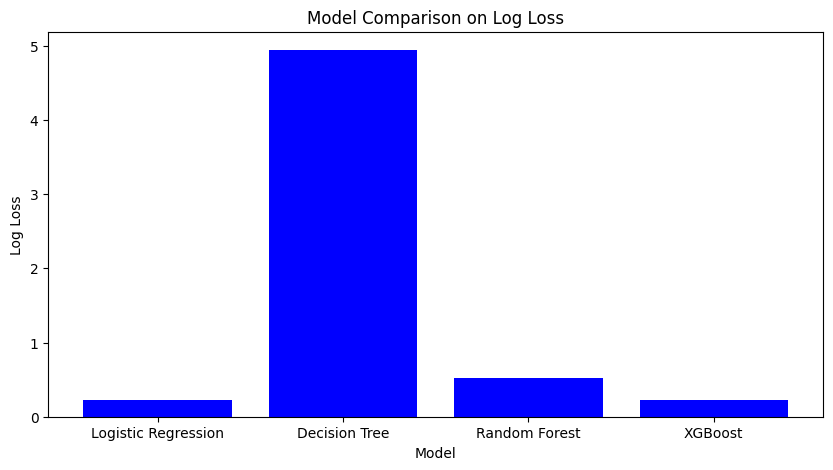

In [5]:
# 选择Random Forest模型的结果进行可视化
losses = []
for model_name, model in models.items():
    loss, _ = create_pipeline(X_2020, y_2020, model)
    losses.append(loss)

# 绘制图表
plt.figure(figsize=(10, 5))
plt.bar(models.keys(), losses, color='blue')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.title('Model Comparison on Log Loss')
plt.show()


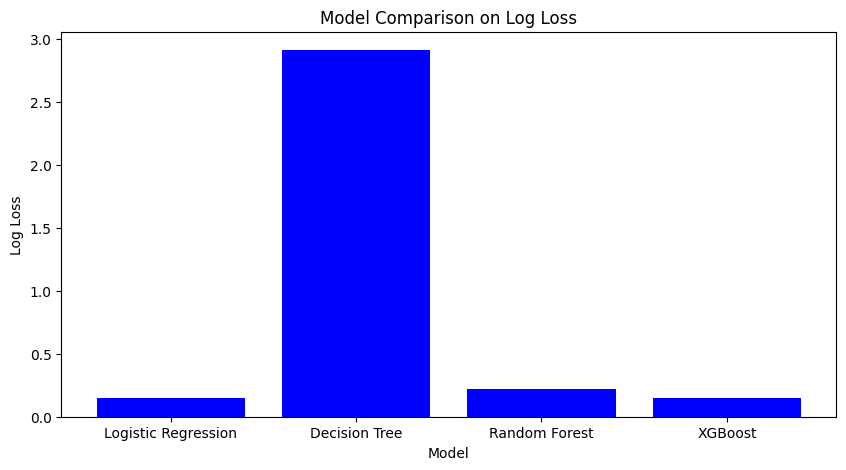

In [6]:
losses = []
for model_name, model in models.items():
    loss, _ = create_pipeline(X_2022, y_2022, model)
    losses.append(loss)

# 绘制图表
plt.figure(figsize=(10, 5))
plt.bar(models.keys(), losses, color='blue')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.title('Model Comparison on Log Loss heart_2022')
plt.show()

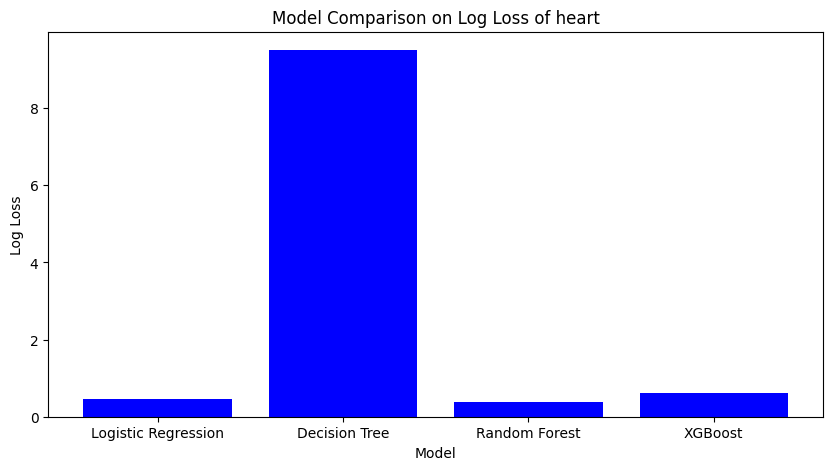

In [7]:
losses = []
for model_name, model in models.items():
    loss, _ = create_pipeline(X_heart, y_heart, model)
    losses.append(loss)

# 绘制图表
plt.figure(figsize=(10, 5))
plt.bar(models.keys(), losses, color='blue')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.title('Model Comparison on Log Loss of heart')
plt.show()

## question
1. unbalanced dataset leading to the poorer performance to "YES", how to solve
2. sparse problem after one-hot coding,there're lots of zeros,how to solve that(in deepFM, we use embedding matrix w),is there general way 
3. we need other models, 
4. in previous study, how do they compare the importance of personal behaviors and accurate numbers
5. how to measure the formance of model, recall seems important


这只是初级版本，解决了上面问题要改一下